In [149]:
# Define the path to the parent directory of data_analysis
parent_dir = '/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/src'

# Add the parent directory to sys.path
sys.path.append(parent_dir)

In [161]:
import sys
import os
import numpy as np
from statsmodels.tsa.stattools import coint, adfuller
from scipy.stats import boxcox
from data_analysis import *

In [162]:
df = load_macro_economic_data("/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/data/dataset.csv")

df = df[df["macro_code"].isin(["gdp_growth", "unemployment_rate"])]

delta = abs(df[df["macro_code"] == "gdp_growth"]["time_series_value"].min())

# Step 1: Initialize with original values
df["transformed_time_series_value"] = df["time_series_value"]

# Step 2: Apply specific transformation
df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"] = (
    df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"].shift(1) - df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"]
)


subset = df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"]
delta = abs(subset.min()) if subset.min() <= 0 else 0 # Calculate delta dynamically to ensure all values are positive
df.loc[df["macro_code"] == "gdp_growth", "transformed_time_series_value"] = ( # Apply sqrt transformation
    np.sqrt(subset + delta) - 2*delta
)


# Step 3: Reshape data into a pivot table
pivot_df = df.pivot(index='pit_date', columns='macro_code', values='transformed_time_series_value')
pivot_df.index = pd.to_datetime(pivot_df.index)  # Ensure datetime index

# # Step 3: Reshape data into a pivot table
# pivot_df = df.pivot(index='pit_date', columns='macro_code', values='time_series_value')
# pivot_df.index = pd.to_datetime(pivot_df.index)  # Ensure datetime index

# Step 4: Interpolate
pivot_df = pivot_df.asfreq('QE').interpolate(method='linear')  # Cubic interpolation
pivot_df = pivot_df.dropna()

print(pivot_df)

Data loaded successfully from /Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/data/dataset.csv.
macro_code  gdp_growth  unemployment_rate
pit_date                                 
1996-12-31    0.103939            0.06500
1997-03-31    0.099771            0.06350
1997-06-30    0.094136            0.06200
1997-09-30    0.101166            0.06050
1997-12-31    0.094136            0.05900
...                ...                ...
2022-09-30    0.130587            0.03675
2022-12-31    0.102555            0.03500
2023-03-31    0.114827            0.03500
2023-06-30    0.130587            0.03500
2023-09-30    0.106692            0.03500

[108 rows x 2 columns]


In [163]:
def remove_outliers(data, method="iqr", threshold=1.5):
    """
    Removes outliers from a DataFrame based on the specified method.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with numeric values.
        method (str): The method to detect outliers. Options are:
                      "iqr" (Interquartile Range) or "zscore" (Z-score).
        threshold (float): Threshold for detecting outliers:
                           - For "iqr", the multiplier for IQR (default=1.5).
                           - For "zscore", the maximum Z-score value (default=3.0).
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """
    if method not in ["iqr", "zscore"]:
        raise ValueError("Invalid method. Choose 'iqr' or 'zscore'.")
    
    filtered_data = data.copy()
    
    if method == "iqr":
        # Apply IQR method
        for col in filtered_data.columns:
            Q1 = filtered_data[col].quantile(0.25)  # 25th percentile
            Q3 = filtered_data[col].quantile(0.75)  # 75th percentile
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            # Mask outliers and replace with NaN
            filtered_data[col] = np.where(
                (filtered_data[col] < lower_bound) | (filtered_data[col] > upper_bound),
                np.nan, filtered_data[col]
            )
            
    elif method == "zscore":
        # Apply Z-score method
        for col in filtered_data.columns:
            mean = filtered_data[col].mean()
            std = filtered_data[col].std()
            
            # Calculate Z-scores
            z_scores = (filtered_data[col] - mean) / std
            filtered_data[col] = np.where(
                np.abs(z_scores) > threshold, np.nan, filtered_data[col]
            )
    
    # Optionally, drop rows with NaN values after filtering
    filtered_data.dropna(inplace=True)
    
    return filtered_data

In [164]:
pivot_df = remove_outliers(pivot_df)

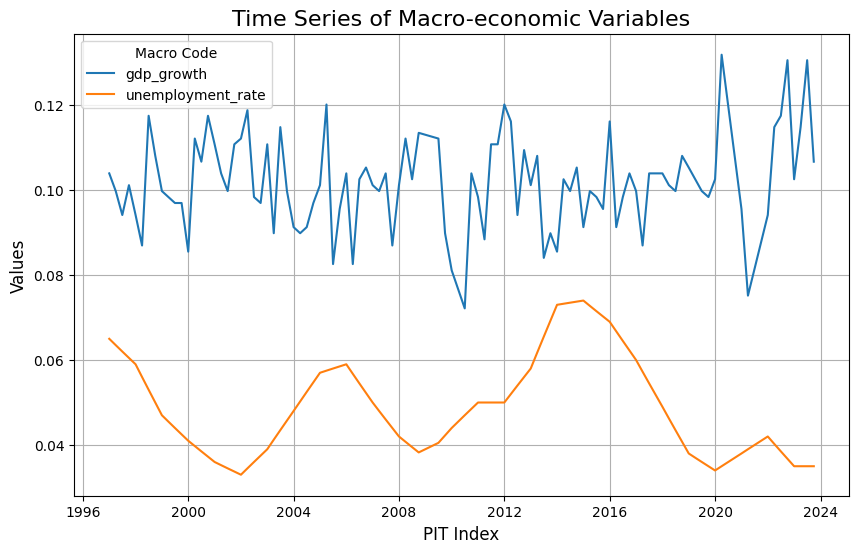

In [165]:
import matplotlib.pyplot as plt

# Step 2: Plot each time series
plt.figure(figsize=(10, 6))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

# Add labels, title, and legend
plt.title("Time Series of Macro-economic Variables", fontsize=16)
plt.xlabel("PIT Index", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.legend(title="Macro Code")
plt.grid(True)

# Show the plot
plt.show()

In [166]:
# Step 2: Perform stationarity tests (optional)
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # p-value

stationarity_results = pivot_df.apply(check_stationarity, axis=0)
print(f"Stationarity test p-values:\n{stationarity_results}\n")

# Step 3: Perform cointegration test
gdp_growth = pivot_df['gdp_growth']
unemployment_rate = pivot_df['unemployment_rate']
# hpi = pivot_df['hpi']
# hicp = pivot_df['hicp']
# inflation = pivot_df['inflation']

pivot_df_list = [gdp_growth, unemployment_rate]

for i in range(len(pivot_df_list)):
    for j in range(len(pivot_df_list)):
        if i < j:
            # Cointegration test
            coint_stat, p_value, critical_values = coint(pivot_df_list[i], pivot_df_list[j])
            
            print(f"Cointegration Test Results:\nStatistic: {coint_stat}\nP-value: {p_value}\nCritical Values: {critical_values}\n")

# Interpretation:
# If p-value < 0.05, the series are cointegrated at a 95% confidence level.

Stationarity test p-values:
macro_code
gdp_growth           1.900556e-12
unemployment_rate    1.310476e-02
dtype: float64

Cointegration Test Results:
Statistic: -8.727161495185
P-value: 4.332001941493518e-13
Critical Values: [-4.0093117 -3.3979133 -3.087134 ]



In [167]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import pandas as pd
import scipy.stats as stats

def check_heteroscedasticity(pivot_df, dependent_var, independent_vars):
    """
    Checks for heteroscedasticity in a pivot DataFrame using the Breusch-Pagan test.

    Parameters:
    - pivot_df (pd.DataFrame): A pivoted DataFrame containing the data.
    - dependent_var (str): The name of the dependent variable column.
    - independent_vars (list): List of column names to use as independent variables.

    Returns:
    - dict: A dictionary containing the results of the Breusch-Pagan test.
    """
    # Ensure the input variables exist in the DataFrame
    if dependent_var not in pivot_df.columns or not all(var in pivot_df.columns for var in independent_vars):
        raise ValueError("One or more specified variables are not in the DataFrame.")
    
    # Extract the dependent and independent variables
    y = pivot_df[dependent_var]
    X = pivot_df[independent_vars]
    X = sm.add_constant(X)  # Add a constant term for the regression

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Perform the Breusch-Pagan test
    test_results = sms.het_breuschpagan(model.resid, X)
    test_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    results = dict(zip(test_labels, test_results))

    return results

def check_heteroscedasticity_single_variable(df, variable, method='levene', group_by=None):
    """
    Checks for heteroscedasticity of a single variable in a time-indexed DataFrame.

    Parameters:
    - df (pd.DataFrame): A DataFrame with a time index and variable columns.
    - variable (str): The column name of the variable to check for heteroscedasticity.
    - method (str): The method to use for testing, either 'levene' (default) or 'bartlett'.
    - group_by (str or None): A column name to group the data by. If None, uses a default grouping strategy.

    Returns:
    - dict: A dictionary containing the test statistic and p-value.
    """
    if variable not in df.columns:
        raise ValueError(f"Variable '{variable}' not found in the DataFrame.")
    
    if group_by:
        if group_by not in df.columns:
            raise ValueError(f"Grouping column '{group_by}' not found in the DataFrame.")
        groups = df.groupby(group_by)[variable]
    else:
        # Default grouping strategy: divide data into quartiles by the index
        df['group'] = pd.qcut(df.index, 4, labels=False)
        groups = df.groupby('group')[variable]
    
    # Extract group values
    group_values = [group[1].dropna().values for group in groups]
    
    # Perform the test
    if method == 'levene':
        test_stat, p_value = stats.levene(*group_values)
    elif method == 'bartlett':
        test_stat, p_value = stats.bartlett(*group_values)
    else:
        raise ValueError("Invalid method. Use 'levene' or 'bartlett'.")
    
    return {"test_statistic": test_stat, "p_value": p_value}

# Example usage
if __name__ == "__main__":
    # Check heteroscedasticity for 'gdp_growth'
    results = check_heteroscedasticity_single_variable(pivot_df, variable='gdp_growth', method='levene')
    print("Heteroscedasticity Test Results:", results)

Heteroscedasticity Test Results: {'test_statistic': np.float64(0.11736243311996918), 'p_value': np.float64(0.9497206117971281)}


In [168]:
print(pivot_df)


macro_code  gdp_growth  unemployment_rate  group
pit_date                                        
1996-12-31    0.103939            0.06500      0
1997-03-31    0.099771            0.06350      0
1997-06-30    0.094136            0.06200      0
1997-09-30    0.101166            0.06050      0
1997-12-31    0.094136            0.05900      0
...                ...                ...    ...
2022-09-30    0.130587            0.03675      3
2022-12-31    0.102555            0.03500      3
2023-03-31    0.114827            0.03500      3
2023-06-30    0.130587            0.03500      3
2023-09-30    0.106692            0.03500      3

[101 rows x 3 columns]


In [169]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Step 1: Sort DataFrame by 'pit_index' and set it as the index
# pivot_df = pivot_df.sort_values('pit_index').set_index('pit_index')

# Step 2: Initialize a dictionary to store results
results = {}

# Step 3: Loop through pairs of variables
for cause in ['gdp_growth', 'unemployment_rate']:
    for effect in ['gdp_growth', 'unemployment_rate']:
        if cause != effect:
            # Perform Granger causality test
            test_result = grangercausalitytests(
                pivot_df[[effect, cause]].dropna(), maxlag=4, verbose=False
            )
            # Store p-values for each lag
            results[(cause, effect)] = {
                lag: test_result[lag][0]['ssr_chi2test'][1] for lag in range(1, 5)
            }

# Step 4: Convert results to a DataFrame for better visualization
granger_results_df = pd.DataFrame(results).T
granger_results_df.columns = [f'lag_{i}' for i in range(1, 5)]
granger_results_df.index.names = ['Cause', 'Effect']

# Display the results
print(granger_results_df)

                                        lag_1     lag_2     lag_3     lag_4
Cause             Effect                                                   
gdp_growth        unemployment_rate  0.325927  0.263835  0.000062  0.000100
unemployment_rate gdp_growth         0.020776  0.001019  0.002029  0.000031


/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/nielsvanwinden/Projects/Projects/Inholland/Scenario_Generator/venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [170]:
def plot_vecm_data(vecm_data, title="VECM Data Visualization"):
    """
    Plots each column in vecm_data as a time series.
    
    Parameters:
        vecm_data (pd.DataFrame): DataFrame where each column is a time series.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))  # Set the figure size
    
    # Plot each time series
    for column in vecm_data.columns:
        plt.plot(vecm_data.index, vecm_data[column], label=column)
    
    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [171]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Set vecm data
vecm_data = df.pivot(index='pit_date', columns='macro_code', values='time_series_value')

# Ensuring index is datetime type
vecm_data.index = pd.to_datetime(vecm_data.index)

# Remove outliers
vecm_data = remove_outliers(vecm_data, method="iqr", threshold=1.0)

# Set the frequency to quarterly
vecm_data = vecm_data.asfreq('QE')

# Interpolate
vecm_data = vecm_data.asfreq('QE').interpolate(method='linear')  # Cubic interpolation

# Fit the VECM
vecm_model = VECM(vecm_data, k_ar_diff=2, coint_rank=1, deterministic='ci')
vecm_fit = vecm_model.fit()

# Summary of the model
print(vecm_fit.summary())
print(vecm_data.count())

Det. terms outside the coint. relation & lagged endog. parameters for equation gdp_growth
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.gdp_growth            0.8795      0.105      8.379      0.000       0.674       1.085
L1.unemployment_rate    -0.6194      0.423     -1.463      0.143      -1.449       0.210
L2.gdp_growth           -0.1256      0.117     -1.075      0.283      -0.355       0.103
L2.unemployment_rate     0.5056      0.396      1.277      0.201      -0.270       1.281
Det. terms outside the coint. relation & lagged endog. parameters for equation unemployment_rate
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
L1.gdp_growth           -0.0068      0.026     -0.265      0.791      -0.057       0.043
L1.unemploym